<a href="https://colab.research.google.com/github/evanreppeto/AIProject/blob/main/Copy_of_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imghdr
import cv2
from tensorflow. keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow. keras.models import Sequential
from tensorflow. keras.models import load_model
from tensorflow. keras.optimizers import Adam, SGD

In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
Data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/AI Project Data (Merged)')
data_iterator = Data.as_numpy_iterator()
batch = data_iterator.next()

Found 7449 files belonging to 8 classes.


In [22]:
#normalizing orparation
Data = Data.map(lambda x,y: (x/255, y))

#split the data set(75:15:10)
train_size = int(len(Data)*.75)
val_size = int(len(Data)*.15)
test_size = int(len(Data)*.1)

train = Data.take(train_size)
val = Data.skip(train_size).take(val_size)
test = Data.skip(train_size+val_size).take(test_size)

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.15,
#     horizontal_flip=True
# )

# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

model = Sequential([
  #data_augmentation,
  base_model,
  GlobalAveragePooling2D(),
  Dense(258, activation='relu'),
  Dense(256, activation='relu'),
  Dense(8, activation='softmax')
])

opt = SGD(learning_rate=0.001, momentum = 0.9)
model.compile(optimizer=opt, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
#model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 258)            │       132,354 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        66,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,915,402 (56.90 MB)

 Trainable params: 14,915,402 (56.90 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import datetime
import tensorflow as tf

logdir = 'Logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

total_epochs = 25
save_interval = 5

for epoch in range(0, total_epochs, save_interval):
    print("Training epochs " + str(epoch + 1) + " to " + str(epoch + save_interval) + "...")

    # Train in blocks of 10 epochs
    hist = model.fit(
        train,
        initial_epoch=epoch,
        epochs=epoch + save_interval,
        validation_data=val,
        callbacks=[tensorboard_callback]
    )

    # Save the model after every 10 epochs
    date_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_name = "/content/drive/MyDrive/New Data/model_epoch" + str(epoch + save_interval) + "_" + date_stamp + ".h5"
    model.save(file_name)
    print("Model saved at epoch " + str(epoch + save_interval) + ": " + file_name)






Training epochs 1 to 5...
Epoch 1/5


KeyboardInterrupt: 

In [ ]:
import datetime
import tensorflow as tf

logdir = 'Logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

full_loss = []
full_val_loss = []
full_acc = []
full_val_acc = []

total_epochs = 50
save_interval = 10

for epoch in range(0, total_epochs, save_interval):
    print(f"Training epochs {epoch + 1} to {epoch + save_interval}...")

    hist = model.fit(
        train,
        initial_epoch=epoch,
        epochs=epoch + save_interval,
        validation_data=val,
        callbacks=[tensorboard_callback]
    )

    # Save history metrics
    full_loss.extend(hist.history['loss'])
    full_val_loss.extend(hist.history['val_loss'])
    full_acc.extend(hist.history['accuracy'])
    full_val_acc.extend(hist.history['val_accuracy'])

    # Save model
    date_stamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_name = f"/content/drive/MyDrive/New Data/model_epoch{epoch + save_interval}_{date_stamp}.h5"
    model.save(file_name)
    print(f"Model saved at epoch {epoch + save_interval}: {file_name}")

Training epochs 1 to 10...
Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 195s 822ms/step - accuracy: 0.1987 - loss: 1.9764 - val_accuracy: 0.3989 - val_loss: 1.6709
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 126s 722ms/step - accuracy: 0.4501 - loss: 1.5103 - val_accuracy: 0.6627 - val_loss: 0.9767
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 145s 833ms/step - accuracy: 0.6824 - loss: 0.9091 - val_accuracy: 0.7316 - val_loss: 0.7796
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 126s 722ms/step - accuracy: 0.7432 - loss: 0.7149 - val_accuracy: 0.7215 - val_loss: 0.7747
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 124s 715ms/step - accuracy: 0.7726 - loss: 0.6569 - val_accuracy: 0.7546 - val_loss: 0.7030
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 125s 718ms/step - accuracy: 0.7936 - loss: 0.5743 - val_accuracy: 0.7509 - val_loss: 0.6882
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 125s 720ms/step - accuracy: 0.8203 - loss: 0.5010 - val_accuracy: 0.7767 - val_loss: 0.6576
Epoch 8/10
 26/174 ━━━━━━━━━━━━━━━━━━━━ 1:29 605m

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(full_loss)+1), full_loss, label='Training Loss', color='teal')
plt.plot(range(1, len(full_val_loss)+1), full_val_loss, label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

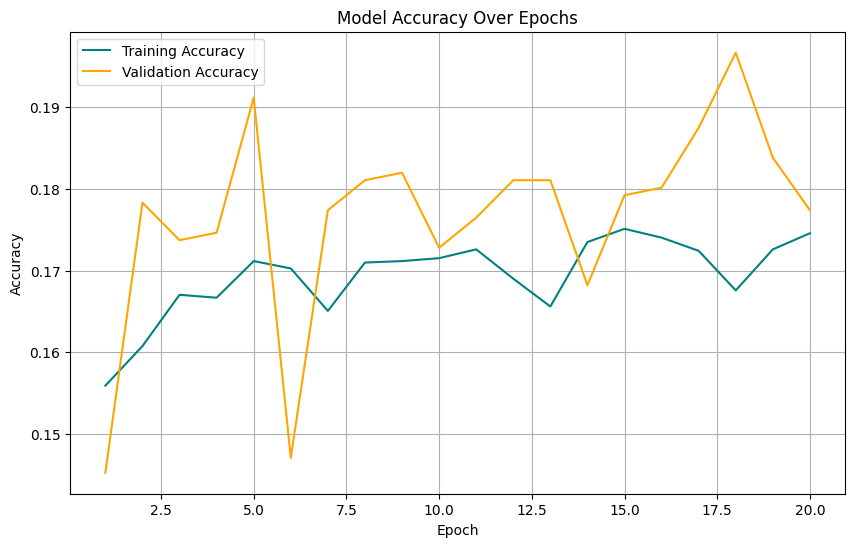

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(full_acc) + 1)

# Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, full_acc, label='Training Accuracy', color='teal')
plt.plot(epochs, full_val_acc, label='Validation Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
new_model = load_model('/content/drive/MyDrive/New Data/model_epoch25_2025-04-14_02-16-46.h5')

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()  # Use CategoricalAccuracy for multi-class

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = new_model.predict(X)

    # Convert y to one-hot encoding for CategoricalAccuracy
    y = tf.keras.utils.to_categorical(y, num_classes=8)

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Precision: 0.6880734
Recall: 0.63920456
Accuracy: 0.6448864


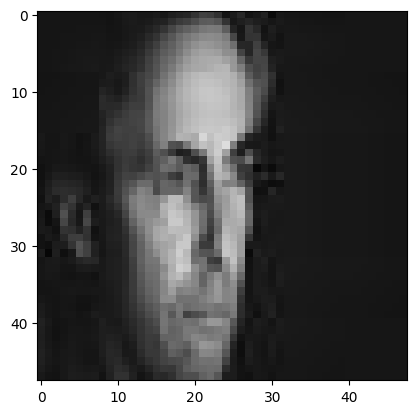

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[2.1755699e-02 3.2303942e-05 1.7809242e-04 5.7618339e-03 1.1631999e-03
  1.5536498e-03 9.6703523e-01 2.5200276e-03]]
Sadness


In [ ]:
#testing pipeline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imghdr
test_img = cv2.imread('/content/drive/MyDrive/AI Project Data/sadness/621462.jpg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

test_img = cv2.resize(test_img, (256,256))
test_img = test_img/255.0
test_img = np.expand_dims(test_img, 0)
test_predicton = model.predict(test_img)

print(test_predicton)
if np.argmax(test_predicton) == 0:
  print('Anger')
elif np.argmax(test_predicton) == 1:
  print('Contempt')
elif np.argmax(test_predicton) == 2:
  print('Disgust')
elif np.argmax(test_predicton) == 3:
  print('Fear')
elif np.argmax(test_predicton) == 4:
  print('Happy')
elif np.argmax(test_predicton) == 5:
  print('Neutral')
elif np.argmax(test_predicton) == 6:
  print('Sadness')
elif np.argmax(test_predicton) == 7:
  print('Surprise')